# Betweenness Centrality 알고리즘 작성 및 성능비교 분석

## 1. 필요한 모듈을 현재 Namespace에 로드

In [1]:
import networkx as net
import operator
from operator import itemgetter, attrgetter
import math
from itertools import combinations, permutations
import random
import numpy as np
import re
import codecs
import csv
import networkx.algorithms as algo
import math
import sys
import time
import pandas as pd
from pandas import Series, DataFrame
from scipy import stats
import matplotlib
matplotlib.use('pgf')
import matplotlib.pyplot as plt

## 2. 4가지 DTN 데이터 셋에 대한 데이터 프로파일 구성
- 초기에는 각 데이터 셋별로 file_name 및 num_nodes 값만 지정함
- 이후 각 단계별로 다른 속성 데이터들을 차례로 할당하게 됨

In [2]:
link_addition_ratio = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

data_profile = {
    "Infocom05": { 
        "file_name": "data_infocom05.csv",
        "num_nodes": 41,
        "median": None,
        "mean": None,
        "std": None,
        "contact_weight_map": None,
        
        "graph": {},
        "numberOfNodes": {},
        "numberOfEdges": {},
        "durationThreshold": {},

        "density": {}, 
        "clustering_coefficient": {},
        "diameter_cc": {},

        "global_bet": {},
        "Brandes_ego_bet": {},
        "Brandes_ego_elapsed_time": {},
        "Brandes_xego_bet": {},
        "Brandes_xego_elapsed_time": {},        

        "Proposed_ego_bet": {},
        "Proposed_ego_elapsed_time": {},
        "Proposed_xego_bet": {},
        "Proposed_xego_elapsed_time": {},      
        
        "ego_global_pearson_corr": {},
        "xego_global_pearson_corr": {},

        "ego_global_spearman_corr": {},
        "xego_global_spearman_corr": {},
        
        "ego_node_coverage_in_connected_component": {},
        "ego_edge_coverage_in_connected_component": {},        
        
        "xego_node_coverage_in_connected_component": {},
        "xego_edge_coverage_in_connected_component": {}    
    },
    "Infocom06": {
        "file_name": "data_infocom06.csv",
        "num_nodes": 99,
        "median": None,
        "mean": None,
        "std": None,
        "contact_weight_map": None,

        "graph": {},
        "numberOfNodes": {},
        "numberOfEdges": {},        
        "durationThreshold": {},

        "density": {},
        "clustering_coefficient": {},
        "diameter_cc": {},

        "global_bet": {},
        "Brandes_ego_bet": {},
        "Brandes_ego_elapsed_time": {},
        "Brandes_xego_bet": {},
        "Brandes_xego_elapsed_time": {},        

        "Proposed_ego_bet": {},
        "Proposed_ego_elapsed_time": {},
        "Proposed_xego_bet": {},
        "Proposed_xego_elapsed_time": {},       
        
        "ego_global_pearson_corr": {},
        "xego_global_pearson_corr": {},

        "ego_global_spearman_corr": {},
        "xego_global_spearman_corr": {},
        
        "ego_node_coverage_in_connected_component": {},
        "ego_edge_coverage_in_connected_component": {},        
        
        "xego_node_coverage_in_connected_component": {},
        "xego_edge_coverage_in_connected_component": {}  
    },
    "Cambridge": {
        "file_name": "data_cambridge.csv",
        "num_nodes": 54,
        "median": None,
        "mean": None,
        "std": None,
        "contact_weight_map": None,

        "graph": {},
        "numberOfNodes": {},
        "numberOfEdges": {},        
        "durationThreshold": {},

        "density": {},
        "clustering_coefficient": {},
        "diameter_cc": {},

        "global_bet": {},
        "Brandes_ego_bet": {},
        "Brandes_ego_elapsed_time": {},
        "Brandes_xego_bet": {},
        "Brandes_xego_elapsed_time": {},        

        "Proposed_ego_bet": {},
        "Proposed_ego_elapsed_time": {},
        "Proposed_xego_bet": {},
        "Proposed_xego_elapsed_time": {},      
        
        "ego_global_pearson_corr": {},
        "xego_global_pearson_corr": {},

        "ego_global_spearman_corr": {},
        "xego_global_spearman_corr": {},
        
        "ego_node_coverage_in_connected_component": {},
        "ego_edge_coverage_in_connected_component": {},        
        
        "xego_node_coverage_in_connected_component": {},
        "xego_edge_coverage_in_connected_component": {}
    }, 
    "Intel": {
        "file_name": "data_intel.csv",
        "num_nodes": 20,
        "median": None,
        "mean": None,
        "std": None,
        "contact_weight_map": None,

        "graph": {},
        "numberOfNodes": {},
        "numberOfEdges": {},        
        "durationThreshold": {},

        "density": {},
        "clustering_coefficient": {},
        "diameter_cc": {},

        "global_bet": {},
        "Brandes_ego_bet": {},
        "Brandes_ego_elapsed_time": {},
        "Brandes_xego_bet": {},
        "Brandes_xego_elapsed_time": {},        

        "Proposed_ego_bet": {},
        "Proposed_ego_elapsed_time": {},
        "Proposed_xego_bet": {},
        "Proposed_xego_elapsed_time": {},      
        
        "ego_global_pearson_corr": {},
        "xego_global_pearson_corr": {},

        "ego_global_spearman_corr": {},
        "xego_global_spearman_corr": {},

        "ego_node_coverage_in_connected_component": {},
        "ego_edge_coverage_in_connected_component": {},        
        
        "xego_node_coverage_in_connected_component": {},
        "xego_edge_coverage_in_connected_component": {}        
    }
}

## 3. 각 노드들에 대한 Cumulative Contact Time 기반 Weight Map 구성

In [3]:
def getContactDurationMap(dataFrame):
    contactMap = {}
    for i in range(0, len(dataFrame)):
        recorder = dataFrame['Recorder'][i]
        recordee = dataFrame['Recordee'][i]
        contactTime = dataFrame['Contact Time'][i]
        if (recorder, recordee) in contactMap:
            contactMap[(recorder, recordee)] = contactMap[(recorder, recordee)] + contactTime + 1
        else:
            contactMap[(recorder, recordee)] = contactTime + 1

    return contactMap, np.median(contactMap.values()), np.mean(contactMap.values()), np.std(contactMap.values())

for data in data_profile.values():
    df = pd.read_csv(data['file_name'])
    data['contact_weight_map'], data['median'], data['mean'], data['std'] = getContactDurationMap(df)

In [4]:
for data_name, data in data_profile.items():
    print "###", data_name
    print data['contact_weight_map'].items()[1:5]
    print "Mean: %5.0f" % data['mean']
    print "Median: %5.0f" % data['median']
    print "Standard Deviation: %5.0f" % data['std']
    print

### Cambridge
[((6, 9), 2187), ((12, 1), 4943), ((7, 12), 40849), ((1, 6), 768)]
Mean:  9961
Median:  2684
Standard Deviation: 26513

### Infocom06
[((39, 70), 1327), ((43, 3), 6382), ((63, 76), 707), ((29, 44), 1366)]
Mean:  3356
Median:  1253
Standard Deviation: 11578

### Intel
[((4, 7), 11018), ((1, 3), 19716), ((9, 1), 125), ((4, 8), 5037)]
Mean: 12495
Median:  4936
Standard Deviation: 27158

### Infocom05
[((21, 28), 369), ((4, 36), 1117), ((7, 25), 2571), ((33, 41), 2151)]
Mean:  3348
Median:  1608
Standard Deviation:  9278



## 4. 각 데이터들에 대한 기본 통계치 출력

In [5]:
class ListTable(list):
    """ Overridden list class which takes a 2-dimensional list of 
        the form [[1,2,3],[4,5,6]], and renders an HTML Table in 
        IPython Notebook. """
    
    def _repr_html_(self):
        html = ["<table>"]
        for row in self:
            html.append("<tr>")
            
            for col in row:
                html.append("<td>{0}</td>".format(col))
            
            html.append("</tr>")
        html.append("</table>")
        return ''.join(html)

table = ListTable()
table.append(['', 'Infocom05', 'Infocom06', 'Cambridge', 'Intel'])
table.append(['Number of Nodes', 
              data_profile['Infocom05']['num_nodes'],
              data_profile['Infocom06']['num_nodes'],
              data_profile['Cambridge']['num_nodes'],
              data_profile['Intel']['num_nodes']])
table.append(['Number of contacts between nodes', '22,459', '170,601', '4,228', '1,364'])
table.append(['Average number of contacts per node pair', '14.3', '20.2', '32.0', '18.9'])
table.append(['Mean of accumulated contact duration per node pair (sec.)', 
              "%5.0f" % data_profile['Infocom05']['mean'],
              "%5.0f" % data_profile['Infocom06']['mean'],
              "%5.0f" % data_profile['Cambridge']['mean'],
              "%5.0f" % data_profile['Intel']['mean']])
table.append(['Median of accumulated contact duration per node pair (sec.)', 
              "%5.0f" % data_profile['Infocom05']['median'],
              "%5.0f" % data_profile['Infocom06']['median'],
              "%5.0f" % data_profile['Cambridge']['median'],
              "%5.0f" % data_profile['Intel']['median']])
table.append(['Data collection period (sec.)', '254,151 (2.9 days)', '337,419 (3.9 days)', '455,610 (5.3 days)', '359,191 (4.2 days)'])
table

,Infocom05,Infocom06,Cambridge,Intel
Number of Nodes,41,99,54,20
Number of contacts between nodes,"22,459","170,601","4,228","1,364"
Average number of contacts per node pair,14.3,20.2,32.0,18.9
Mean of accumulated contact duration per node pair (sec.),3348,3356,9961,12495
Median of accumulated contact duration per node pair (sec.),1608,1253,2684,4936
Data collection period (sec.),"254,151 (2.9 days)","337,419 (3.9 days)","455,610 (5.3 days)","359,191 (4.2 days)"


## 5. Weight Map으로 부터 각 Link Addition Ratio 별로 Duration Threshold 및 Graph 얻기

In [6]:
def mean(values):
    if len(values) == 0:
        return None
    return sum(values) / len(values)

def get_edgeList_by_threshold(n, map, median, threshold):
    contactMap = sorted(map.iteritems(), key=operator.itemgetter(1))
    num = int(math.ceil(float(len(contactMap)) * threshold))

    edgeList = []
    duration = 0
    for i in range(0, num):
        item = contactMap.pop()
        edge = item[0]
        duration = item[1]
        edgeList.append(edge)

    return edgeList, duration

for data in data_profile.values():
    for ratio in link_addition_ratio:
        edgeList, duration = get_edgeList_by_threshold(data['num_nodes'], 
                                                       data['contact_weight_map'],
                                                       data['median'], 
                                                       ratio)
        data['durationThreshold'][ratio] = duration
        data['graph'][ratio] = net.Graph(edgeList)
        data['numberOfNodes'][ratio] = data['graph'][ratio].number_of_nodes()
        data['numberOfEdges'][ratio] = data['graph'][ratio].number_of_edges()

In [7]:
for data_name, data in data_profile.items():
    print "###", data_name
    for ratio in sorted(data['durationThreshold']):
        print "%s - %d - %d - %d" % (ratio, 
                                     data['durationThreshold'][ratio], 
                                     data['numberOfNodes'][ratio],
                                     data['numberOfEdges'][ratio])
    print

### Cambridge
0.1 - 19606 - 8 - 8
0.2 - 7786 - 12 - 15
0.3 - 4470 - 12 - 22
0.4 - 3246 - 12 - 29
0.5 - 2709 - 12 - 39
0.6 - 2187 - 12 - 48
0.7 - 1806 - 12 - 53
0.8 - 1566 - 12 - 59
0.9 - 1318 - 12 - 64

### Infocom06
0.1 - 6381 - 94 - 576
0.2 - 3883 - 97 - 1102
0.3 - 2568 - 98 - 1605
0.4 - 1815 - 98 - 2108
0.5 - 1253 - 98 - 2559
0.6 - 862 - 98 - 2995
0.7 - 506 - 98 - 3370
0.8 - 251 - 98 - 3716
0.9 - 10 - 98 - 4046

### Intel
0.1 - 24329 - 5 - 5
0.2 - 16725 - 9 - 9
0.3 - 10915 - 9 - 13
0.4 - 6572 - 9 - 16
0.5 - 5037 - 9 - 19
0.6 - 4122 - 9 - 25
0.7 - 2211 - 9 - 28
0.8 - 1200 - 9 - 31
0.9 - 9 - 9 - 35

### Infocom05
0.1 - 5921 - 39 - 91
0.2 - 3818 - 40 - 191
0.3 - 2905 - 40 - 285
0.4 - 2167 - 40 - 363
0.5 - 1609 - 41 - 452
0.6 - 1214 - 41 - 531
0.7 - 846 - 41 - 605
0.8 - 468 - 41 - 672
0.9 - 141 - 41 - 740



## 6. 각 Link Addition Ratio 별로 구한 그래프에 대한 density, clustering_coefficient, diameter 구하기
- diameter는 largest connected component에 대해 계산함

In [8]:
for data in data_profile.values():
    for ratio in link_addition_ratio:
        data['density'][ratio] = net.density(data['graph'][ratio])
        data['clustering_coefficient'][ratio] = mean(algo.clustering(data['graph'][ratio]).values())
        data['diameter_cc'][ratio] = algo.diameter(list(algo.connected_component_subgraphs(data['graph'][ratio]))[0])

In [9]:
for data_name, data in data_profile.items():
    print "###", data_name
    for ratio in sorted(data['density']):
        print "%s - density: %f, clustering_coefficient: %f, diameter_cc: %f" % (ratio, 
                                                                                 data['density'][ratio],
                                                                                 data['clustering_coefficient'][ratio],
                                                                                 data['diameter_cc'][ratio])
    print

### Cambridge
0.1 - density: 0.285714, clustering_coefficient: 0.458333, diameter_cc: 3.000000
0.2 - density: 0.227273, clustering_coefficient: 0.347222, diameter_cc: 5.000000
0.3 - density: 0.333333, clustering_coefficient: 0.491667, diameter_cc: 3.000000
0.4 - density: 0.439394, clustering_coefficient: 0.648810, diameter_cc: 3.000000
0.5 - density: 0.590909, clustering_coefficient: 0.669577, diameter_cc: 3.000000
0.6 - density: 0.727273, clustering_coefficient: 0.781854, diameter_cc: 2.000000
0.7 - density: 0.803030, clustering_coefficient: 0.833027, diameter_cc: 2.000000
0.8 - density: 0.893939, clustering_coefficient: 0.893248, diameter_cc: 2.000000
0.9 - density: 0.969697, clustering_coefficient: 0.968350, diameter_cc: 2.000000

### Infocom06
0.1 - density: 0.131778, clustering_coefficient: 0.400435, diameter_cc: 7.000000
0.2 - density: 0.236684, clustering_coefficient: 0.483801, diameter_cc: 5.000000
0.3 - density: 0.337681, clustering_coefficient: 0.564143, diameter_cc: 4.000000

## 8. Global Betweenness Centrality를 각 노드별로 구하기

In [10]:
def get_Global_Betweenness_List(g):
    return net.betweenness_centrality(g)

for data in data_profile.values():
    for ratio in link_addition_ratio:
        data['global_bet'][ratio] = get_Global_Betweenness_List(data['graph'][ratio])       

## 9. 기존 Brandnes Betweenness 알고리즘을 통해 ego 및 xEgo Betweenness 구하기
- [주의] 아래 코드 수행 시간: 약 2~3분

In [11]:
def brandes_betweenness(G):
    betweenness=dict.fromkeys(G,0.0) # b[v]=0 for v in G
    nodes = G
    for s in nodes:
        S, P, sigma = single_source_shortest_path_basic(G,s)
        betweenness = accumulate_basic(betweenness,S,P,sigma,s)
    betweenness = rescale(betweenness, len(G))
    return betweenness

def single_source_shortest_path_basic(G, s):
    S=[]
    P={}
    for v in G:
        P[v]=[]
    sigma=dict.fromkeys(G,0.0)    # sigma[v]=0 for v in G
    D={}
    sigma[s]=1.0
    D[s]=0
    Q=[s]
    while Q:   # use BFS to find shortest paths
        v=Q.pop(0)
        S.append(v)
        Dv=D[v]
        sigmav=sigma[v]
        for w in G[v]:
            if w not in D:
                Q.append(w)
                D[w]=Dv+1
            if D[w]==Dv+1:   # this is a shortest path, count paths
                sigma[w] += sigmav
                P[w].append(v) # predecessors 
    return S,P,sigma

def accumulate_basic(betweenness, S, P, sigma, s):
    delta=dict.fromkeys(S, 0)
    while S:
        w=S.pop()
        coeff=(1.0+delta[w])/sigma[w]
        for v in P[w]:
            delta[v] += sigma[v]*coeff
        if w != s:
            betweenness[w]+=delta[w]
    return betweenness

def rescale(betweenness, n):
    if n <= 2:
        scale=None  # no normalization b=0 for all nodes
    else:
        scale=1.0/((n-1)*(n-2))

    if scale is not None:
        for v in betweenness:
            betweenness[v] *= scale
    return betweenness

def get_xego_graph(g, center):
    g2 = net.Graph()
    g2.add_node(center)
    firstNeighbors = g.neighbors(center)

    secondNeighbors = []
    for neighbor in firstNeighbors:
        g2.add_edge(neighbor, center)
        secondNeighborsOfNode = g.neighbors(neighbor)
        for nneighbor in secondNeighborsOfNode:
            if (nneighbor == center):
                continue
            if nneighbor in firstNeighbors:
                g2.add_edge(neighbor, nneighbor)
            else:
                g2.add_edge(neighbor, nneighbor)
                secondNeighbors.append(nneighbor)
    secondNeighbors = list(set(secondNeighbors))
    return g2, firstNeighbors, secondNeighbors

def get_brandnes_ego_betweenness_and_elapsed_time(g):
    elapsed_time = 0.0
    numNodes = g.number_of_nodes()
    centrality_map = {} 
    for node in g.nodes():
        egoNet = net.ego_graph(g, node)
        #######
        start_time = time.time()        
        centrality_map[node] = brandes_betweenness(egoNet).get(node)
        end_time = time.time()
        #######
        elapsed_time = elapsed_time + (end_time - start_time)     
    return centrality_map, elapsed_time

def get_brandnes_xego_betweenness_and_elapsed_time(g):
    elapsed_time = 0.0
    numNodes = g.number_of_nodes()
    centrality_map = {}
    for node in g.nodes():
        xEgoNet, firstNeighbors, secondNeighbors = get_xego_graph(g, node)
        #######
        start_time = time.time()
        centrality_map[node] = brandes_betweenness(xEgoNet).get(node)
        end_time = time.time()
        #######
        elapsed_time = elapsed_time + (end_time - start_time)
    return centrality_map, elapsed_time

for data in data_profile.values():
    for ratio in link_addition_ratio:
        data['Brandes_ego_bet'][ratio], data['Brandes_ego_elapsed_time'][ratio] = get_brandnes_ego_betweenness_and_elapsed_time(data['graph'][ratio])
        data['Brandes_xego_bet'][ratio], data['Brandes_xego_elapsed_time'][ratio] = get_brandnes_xego_betweenness_and_elapsed_time(data['graph'][ratio])

## 10. 제안하는 Ego Betweenness 및 xEgo Betweenness 알고리즘 구현
- [주의] 아래 코드 수행 시간: 약 1~2분

In [12]:
def proposed_ego_betweenness(G, center, fe, node2Index, index2Node):
    nodes = G.nodes()
    nodes.remove(center)

    lenOfFirstNeighbors = len(fe)
    table = dict.fromkeys(index2Node.keys(), 0.0)
    for i in index2Node.keys():
        delta=dict.fromkeys(index2Node.keys(), 0.0)
        table[i] = delta

    betweenness = 0.0

    for i in range(1, lenOfFirstNeighbors+1):
        N_i = G[index2Node[i]].keys()
        for j in range(i+1, lenOfFirstNeighbors+1):
            N_j = G[index2Node[j]].keys()
            table[i][j] = dependency1(index2Node[j], N_i, N_j)
            betweenness += table[i][j]

    betweenness = my_rescale(betweenness, len(G))

    return betweenness

def proposed_xego_betweenness(G, center, firstNeighbors, secondNeighbors, node2Index, index2Node):
    nodes = G.nodes()
    nodes.remove(center)

    lenOfFirstAndSecondNeigbors = len(nodes)
    lenOfFirstNeighbors = len(firstNeighbors)

    table = dict.fromkeys(index2Node.keys(), 0.0)
    for i in index2Node.keys():
        delta=dict.fromkeys(index2Node.keys(), 0.0)
        table[i] = delta

    betweenness = 0.0

    for i in range(1, lenOfFirstNeighbors+1):
        N_i = G[index2Node[i]].keys()
        for j in range(i+1, lenOfFirstNeighbors+1):
            N_j = G[index2Node[j]].keys()
            table[i][j] = dependency1(index2Node[j], N_i, N_j)
            betweenness += table[i][j]
        for j in range(lenOfFirstNeighbors+1, lenOfFirstAndSecondNeigbors+1):
            N_j = G[index2Node[j]].keys()
            table[i][j] = dependency2(i, N_j, node2Index, index2Node, table)
            betweenness += table[i][j]

    for i in range(lenOfFirstNeighbors+1, lenOfFirstAndSecondNeigbors+1):
        for j in range(i+1, lenOfFirstAndSecondNeigbors+1):
            N_j = G[index2Node[j]].keys()
            table[i][j] = dependency2(i, N_j, node2Index, index2Node, table)
            betweenness += table[i][j]

    betweenness = my_rescale(betweenness, len(G))

    return betweenness

def dependency1(jnode, Ni, Nj):
    if jnode in Ni:
        return 0.0
    else: 
        return 1.0 / len(set(Ni) & set(Nj))

def dependency2(i, Nj, node2Index, index2Node, table):
    values = []
    for neighbor in Nj:
        f = 0.0 
        if (i < node2Index[neighbor]):
            f = table[i][node2Index[neighbor]]
        else: 
            f = table[node2Index[neighbor]][i]
        if (f == 0.0): 
            return 0.0
        else: 
            values.append(f)
    return stats.hmean(values)

def my_rescale(betweenness, n):
    if n <= 2:
        scale = None # no normalization b=0 for all nodes
    else: 
        scale = 2.0/((n-1)*(n-2))

    if scale is not None:
        betweenness *= scale
    return betweenness

def get_ego_graph(g, center):
    g2 = net.Graph()
    node2Index = {}
    index2Node = {}
    g2.add_node(center)
    firstNeighbors = g.neighbors(center)

    node2Index[center] = 0
    index2Node[0] = center

    i = 1;
    for neighbor in firstNeighbors:
        node2Index[neighbor] = i
        index2Node[i] = neighbor
        i += 1;

    for neighbor in firstNeighbors:
        g2.add_edge(neighbor, center)
        NeighborsOfNeighbors = g.neighbors(neighbor)
        for nneighbor in NeighborsOfNeighbors:
            if (nneighbor == center):
                continue
            if nneighbor in firstNeighbors:
                g2.add_edge(neighbor, nneighbor)
    return g2, firstNeighbors, node2Index, index2Node

def get_proposed_ego_betweenness_and_elapsed_time(g):
    elapsed_time = 0.0
    numNodes = g.number_of_nodes()
    centrality_map = {} 
    for node in g.nodes():
        egoNet, firstNeighbors, node2Index, index2Node = get_ego_graph(g, node)   
        #######
        start_time = time.time()
        centrality_map[node] = proposed_ego_betweenness(egoNet, node, firstNeighbors, node2Index, index2Node)
        end_time = time.time()
        #######
        elapsed_time = elapsed_time + (end_time - start_time)             
    return centrality_map, elapsed_time

def get_xego_graph(g, center):
    g2 = net.Graph()
    node2Index = {}
    index2Node = {}
    g2.add_node(center)
    firstNeighbors = g.neighbors(center)

    node2Index[center] = 0
    index2Node[0] = center

    i = 1;
    for neighbor in firstNeighbors:
        node2Index[neighbor] = i
        index2Node[i] = neighbor
        i += 1;

    secondNeighbors = []
    for neighbor in firstNeighbors:
        g2.add_edge(neighbor, center)
        secondNeighborsOfNode = g.neighbors(neighbor)
        for nneighbor in secondNeighborsOfNode:
            if (nneighbor == center):
                continue
            if nneighbor in firstNeighbors:
                g2.add_edge(neighbor, nneighbor)
            else:
                g2.add_edge(neighbor, nneighbor)
                if not (nneighbor in secondNeighbors):
                    secondNeighbors.append(nneighbor)
                    node2Index[nneighbor] = i
                    index2Node[i] = nneighbor                   
                    i += 1
    return g2, firstNeighbors, secondNeighbors, node2Index, index2Node

def get_proposed_xego_betweenness_and_elapsed_time(g):
    elapsed_time = 0.0
    numNodes = g.number_of_nodes()
    centrality_map = {} 
    for node in g.nodes():
        xEgoNet, firstNeighbors, secondNeighbors, node2Index, index2Node = get_xego_graph(g, node)    
        #######
        start_time = time.time()
        centrality_map[node] = proposed_xego_betweenness(xEgoNet, node, firstNeighbors, secondNeighbors, node2Index, index2Node)
        end_time = time.time()
        #######
        elapsed_time = elapsed_time + (end_time - start_time)             
    return centrality_map, elapsed_time

for data in data_profile.values():
    for ratio in link_addition_ratio:
        data['Proposed_ego_bet'][ratio], data['Proposed_ego_elapsed_time'][ratio] = get_proposed_ego_betweenness_and_elapsed_time(data['graph'][ratio])
        data['Proposed_xego_bet'][ratio], data['Proposed_xego_elapsed_time'][ratio] = get_proposed_xego_betweenness_and_elapsed_time(data['graph'][ratio])

## 11. Brandes 기법과 제안 기법으로 구한 ego 및 xego betweenness 값의 동일성 비교

In [13]:
for data_name, data in data_profile.items():
    print "###", data_name
    isEqual = True
    for ratio in link_addition_ratio:
        for node in data['graph'][ratio].nodes():
            if data['Proposed_ego_bet'][ratio][node] - data['Brandes_ego_bet'][ratio][node] > 0.00001:
                isEqual = False
                print ratio, node, data['Brandes_ego_bet'][ratio][node], data['Proposed_ego_bet'][ratio][node]
                break
            if data['Proposed_xego_bet'][ratio][node] - data['Brandes_xego_bet'][ratio][node] > 0.00001:
                isEqual = False
                print ratio, node, data['Brandes_xego_bet'][ratio][node], data['Proposed_xego_bet'][ratio][node]
                break    
    if isEqual:
        print "All betweenness values are equals!"
    else:
        print "Fail!"
    print

### Cambridge
All betweenness values are equals!

### Infocom06
All betweenness values are equals!

### Intel
All betweenness values are equals!

### Infocom05
All betweenness values are equals!



## 12. Correlation 구하기

In [14]:
for data in data_profile.values():
    for ratio in link_addition_ratio:
        data['ego_global_pearson_corr'][ratio] = stats.pearsonr(data['Proposed_ego_bet'][ratio].values(), 
                                                                data['global_bet'][ratio].values())[0]
        data['xego_global_pearson_corr'][ratio] = stats.pearsonr(data['Proposed_xego_bet'][ratio].values(), 
                                                                data['global_bet'][ratio].values())[0]
        
        data['ego_global_spearman_corr'][ratio] = stats.spearmanr(data['Proposed_ego_bet'][ratio].values(), 
                                                                  data['global_bet'][ratio].values())[0]
        data['xego_global_spearman_corr'][ratio] = stats.spearmanr(data['Proposed_xego_bet'][ratio].values(), 
                                                                   data['global_bet'][ratio].values())[0]

for data_name, data in data_profile.items():
    print "###", data_name
    for ratio in link_addition_ratio:
        print "%f: Pearson %7.5f - %7.5f, Spearman %7.5f - %7.5f" % (ratio, data['ego_global_pearson_corr'][ratio], data['xego_global_pearson_corr'][ratio], data['ego_global_spearman_corr'][ratio], data['xego_global_spearman_corr'][ratio])
    print     

### Cambridge
0.100000: Pearson 0.97435 - 1.00000, Spearman 0.98974 - 1.00000
0.200000: Pearson 0.89201 - 0.95593, Spearman 0.98297 - 0.99248
0.300000: Pearson 0.58546 - 0.96510, Spearman 0.86920 - 0.94849
0.400000: Pearson 0.50182 - 0.87949, Spearman 0.75177 - 0.92199
0.500000: Pearson 0.30942 - 0.98596, Spearman 0.58042 - 0.98601
0.600000: Pearson 0.91412 - 1.00000, Spearman 0.94921 - 1.00000
0.700000: Pearson 0.70612 - 1.00000, Spearman 0.75571 - 1.00000
0.800000: Pearson 0.81575 - 1.00000, Spearman 0.73665 - 0.99822
0.900000: Pearson 1.00000 - 1.00000, Spearman 1.00000 - 1.00000

### Infocom06
0.100000: Pearson 0.21325 - 0.26149, Spearman 0.31790 - 0.45351
0.200000: Pearson 0.04869 - 0.58147, Spearman 0.12212 - 0.64588
0.300000: Pearson 0.34373 - 0.99405, Spearman 0.17271 - 0.98294
0.400000: Pearson 0.55874 - 0.99932, Spearman 0.15316 - 0.99629
0.500000: Pearson 0.77453 - 0.99969, Spearman 0.17749 - 0.99890
0.600000: Pearson 0.29430 - 0.98527, Spearman 0.39760 - 0.95441
0.700000: P

## 13. Ego Network 및 xEgo Network 의 Coverage 구하기

In [15]:
def getNumOfNodesEdgesInConnectedComponent(g):
    numNodeList = dict.fromkeys(g, 0)
    numEdgeList = dict.fromkeys(g, 0)
    h = list(net.connected_component_subgraphs(g))
    numOfComponent = len(h)
    for x in g.nodes():
        for i in xrange(0, numOfComponent):
            if x in h[i].nodes():
                numNodeList[x]=len(h[i].nodes())
                numEdgeList[x]=len(h[i].edges())
                break
    return numNodeList, numEdgeList

def get_ego_coverage(g, numNodeInConnectedComponent, numEdgeInConnectedComponent):
    numNodeRateList = dict.fromkeys(g, 0.0)
    numEdgeRateList = dict.fromkeys(g, 0.0)
    numNodes = g.number_of_nodes()
    for node in g.nodes():
        egoNet = get_ego_graph(g, node)[0]
        if (numNodeInConnectedComponent[node] != 0):
            numNodeRateList[node] = float(egoNet.number_of_nodes())/float(numNodeInConnectedComponent[node])
        if (numEdgeInConnectedComponent[node] != 0):
            numEdgeRateList[node] = float(egoNet.number_of_edges())/float(numEdgeInConnectedComponent[node])		
    return numNodeRateList, numEdgeRateList

def get_xego_coverage(g, numNodeInConnectedComponent, numEdgeInConnectedComponent):
    numNodeRateList = dict.fromkeys(g, 0.0)
    numEdgeRateList = dict.fromkeys(g, 0.0)
    numNodes = g.number_of_nodes()
    for node in g.nodes():
        xEgoNet = get_xego_graph(g, node)[0]
        if (numNodeInConnectedComponent[node] != 0):
            numNodeRateList[node] = float(xEgoNet.number_of_nodes())/float(numNodeInConnectedComponent[node])
        if (numEdgeInConnectedComponent[node] != 0):
            numEdgeRateList[node] = float(xEgoNet.number_of_edges())/float(numEdgeInConnectedComponent[node])		
    return numNodeRateList, numEdgeRateList

def getAverageFromDict(dic):
    sumValue = 0.0
    for i, v in dic.items():
        sumValue = sumValue + v
    return sumValue / len(dic)

for data in data_profile.values():
    for ratio in link_addition_ratio:
        numNodesCC, numEdgesCC = getNumOfNodesEdgesInConnectedComponent(data['graph'][ratio])
        numNodes_ego_coverage, numEdges_ego_coverage = get_ego_coverage(data['graph'][ratio], numNodesCC, numEdgesCC)
        numNodes_xego_coverage, numEdges_xego_coverage = get_xego_coverage(data['graph'][ratio], numNodesCC, numEdgesCC)
        data['ego_node_coverage_in_connected_component'][ratio] = getAverageFromDict(numNodes_ego_coverage)
        data['ego_edge_coverage_in_connected_component'][ratio] = getAverageFromDict(numEdges_ego_coverage)
        data['xego_node_coverage_in_connected_component'][ratio] = getAverageFromDict(numNodes_xego_coverage)
        data['xego_edge_coverage_in_connected_component'][ratio] = getAverageFromDict(numEdges_xego_coverage)
        
for data_name, data in data_profile.items():
    print "###", data_name
    for ratio in link_addition_ratio:
        print ratio, data['ego_node_coverage_in_connected_component'][ratio], data['ego_edge_coverage_in_connected_component'][ratio],
        print data['xego_node_coverage_in_connected_component'][ratio], data['xego_edge_coverage_in_connected_component'][ratio]
    print

### Cambridge
0.1 0.666666666667 0.607142857143 0.916666666667 0.821428571429
0.2 0.483333333333 0.422619047619 0.683333333333 0.613095238095
0.3 0.6 0.488095238095 0.916666666667 0.77380952381
0.4 0.486111111111 0.382183908046 0.916666666667 0.709770114943
0.5 0.625 0.480769230769 0.986111111111 0.848290598291
0.6 0.75 0.625 1.0 0.940972222222
0.7 0.819444444444 0.718553459119 1.0 0.963836477987
0.8 0.902777777778 0.827683615819 1.0 0.991525423729
0.9 0.972222222222 0.947916666667 1.0 1.0

### Infocom06
0.1 0.141014033499 0.0852171985816 0.629244001811 0.293439716312
0.2 0.244553087469 0.160383183341 0.870974598788 0.46741631897
0.3 0.344439816743 0.233492275415 0.941274468971 0.599173501176
0.4 0.449187838401 0.329812570189 0.955226988755 0.715215118305
0.5 0.543107038734 0.428260401464 0.961890878801 0.797058800073
0.6 0.633902540608 0.537893087118 0.980216576426 0.858658989472
0.7 0.711995002082 0.634824077999 0.986047480217 0.901087022346
0.8 0.784048313203 0.732801893632 0.999375

## 14. Correlation 그래프 생성 

In [16]:
class SortedDisplayDict(dict):
    def __str__(self):
        return "{" + ", ".join("%r: %r" % (key, self[key]) for key in sorted(self)) + "}"
    def ordered_keys(self):
        return sorted(self.keys())
    
dic = SortedDisplayDict(data_profile['Infocom05']['xego_global_spearman_corr'])

print dic
print [dic[x] for x in dic.ordered_keys()]

{0.1: 0.4940567002323909, 0.2: 0.4819401444788442, 0.3: 0.70956848030018771, 0.4: 0.83902439024390252, 0.5: 0.9233449477351916, 0.6: 0.94756097560975605, 0.7: 0.99965156794425081, 0.8: 1.0, 0.9: 1.0}
[0.4940567002323909, 0.4819401444788442, 0.70956848030018771, 0.83902439024390252, 0.9233449477351916, 0.94756097560975605, 0.99965156794425081, 1.0, 1.0]


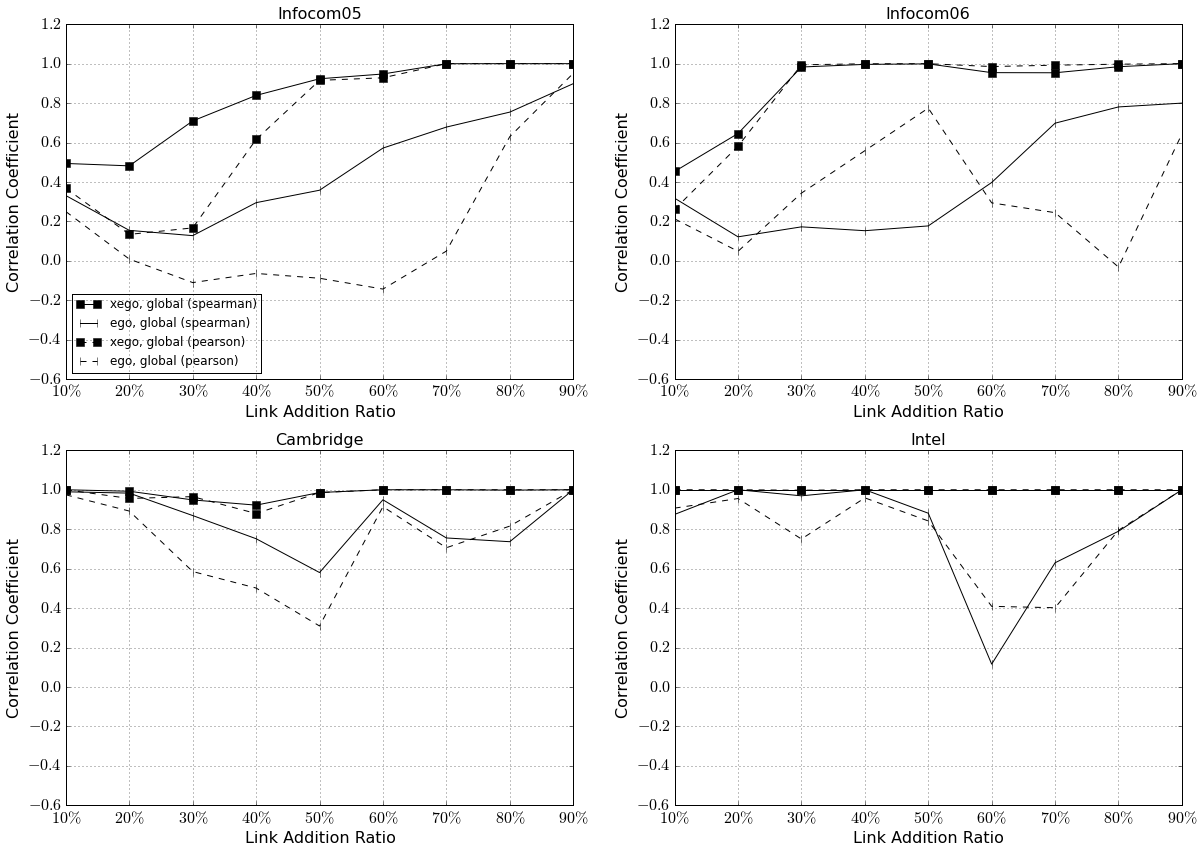

In [21]:
%matplotlib inline

xticklabels = [r'$10\%$', r'$20\%$', r'$30\%$', r'$40\%$', r'$50\%$', r'$60\%$', r'$70\%$', r'$80\%$', r'$90\%$']
yticklabels = [r'$-0.6$', r'$-0.4$', r'$-0.2$', r'$0.0$', r'$0.2$', r'$0.4$', r'$0.6$', r'$0.8$', r'$1.0$', r'$1.2$']
            
ind = np.arange(9)
barWidth = 0.35
fig, axes = plt.subplots(2, 2, figsize=(20, 14))
subfigures = {}
for data_name in data_profile.keys():
    if data_name == 'Infocom05':
        subfigures[data_name] = axes[0][0]
    if data_name == 'Infocom06':
        subfigures[data_name] = axes[0][1]
    if data_name == 'Cambridge':
        subfigures[data_name] = axes[1][0]
    if data_name == 'Intel':
        subfigures[data_name] = axes[1][1]

for data_name in data_profile.keys():
    subfigures[data_name].set_xticks(ind + barWidth/2.) 
    subfigures[data_name].set_xticklabels(xticklabels, fontsize=16)
    subfigures[data_name].set_ylim([-0.6, 1.2])
    subfigures[data_name].set_yticklabels(yticklabels, fontsize=16)
    
    corr_dic = SortedDisplayDict(data_profile[data_name]['xego_global_spearman_corr'])
    corr_value_list = [corr_dic[x] for x in corr_dic.ordered_keys()]
    subfigures[data_name].plot(ind + barWidth/2., 
                               corr_value_list, 
                               color='k', linestyle='-', marker='s', markersize=8, 
                               label='xego, global (spearman)')
    
    corr_dic = SortedDisplayDict(data_profile[data_name]['ego_global_spearman_corr'])
    corr_value_list = [corr_dic[x] for x in corr_dic.ordered_keys()]
    subfigures[data_name].plot(ind + barWidth/2., 
                               corr_value_list, 
                               color='k', linestyle='-', marker='|', markersize=8, 
                               label='ego, global (spearman)')
    
    corr_dic = SortedDisplayDict(data_profile[data_name]['xego_global_pearson_corr'])
    corr_value_list = [corr_dic[x] for x in corr_dic.ordered_keys()]
    subfigures[data_name].plot(ind + barWidth/2., 
                               corr_value_list, 
                               color='k', linestyle='--', marker='s', markersize=8, 
                               label='xego, global (pearson)')
    
    corr_dic = SortedDisplayDict(data_profile[data_name]['ego_global_pearson_corr'])
    corr_value_list = [corr_dic[x] for x in corr_dic.ordered_keys()]
    subfigures[data_name].plot(ind + barWidth/2., 
                               corr_value_list, 
                               color='k', linestyle='--', marker='|', markersize=8, 
                               label='ego, global (pearson)')
    
    subfigures[data_name].set_xlabel('Link Addition Ratio', fontsize=16)
    subfigures[data_name].set_ylabel('Correlation Coefficient', fontsize=16)
    subfigures[data_name].grid(True)
    subfigures[data_name].set_title(data_name, fontsize=16)
    if data_name == 'Infocom05':
        subfigures[data_name].legend(loc = 3)
    #plt.savefig(str(data_name) + '_correlation.pdf', bbox_inches='tight')

## 15. Clustering coefficient 및 diameter of connected component 그래프 생성 

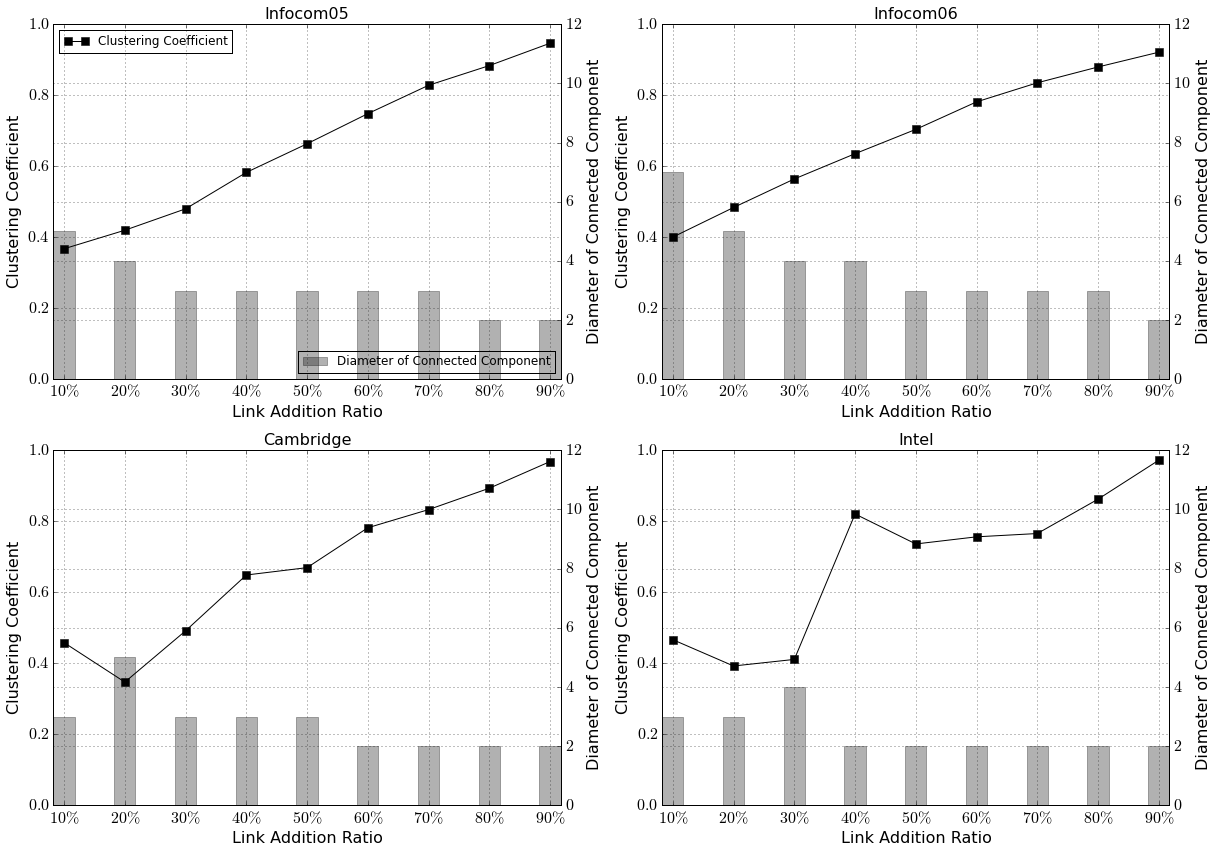

In [22]:
xticklabels = [r'$10\%$', r'$20\%$', r'$30\%$', r'$40\%$', r'$50\%$', r'$60\%$', r'$70\%$', r'$80\%$', r'$90\%$']
yticklabels = [r'$0.0$', r'$0.2$', r'$0.4$', r'$0.6$', r'$0.8$', r'$1.0$']
yticklabels2 = [r'$0$', r'$2$', r'$4$', r'$6$', r'$8$', r'$10$', r'$12$']
            
fig, axes = plt.subplots(2, 2, figsize=(20, 14))
subfigures = {}
for data_name in data_profile.keys():
    if data_name == 'Infocom05':
        subfigures[data_name] = axes[0][0]
    if data_name == 'Infocom06':
        subfigures[data_name] = axes[0][1]
    if data_name == 'Cambridge':
        subfigures[data_name] = axes[1][0]
    if data_name == 'Intel':
        subfigures[data_name] = axes[1][1]
        
for data_name in data_profile.keys():        
    subfigures[data_name].set_xticks(ind + barWidth/2.)
    subfigures[data_name].set_xticklabels(xticklabels, fontsize=16)
    subfigures[data_name].set_ylim([0.0, 1.0])
    subfigures[data_name].set_yticklabels(yticklabels, fontsize=16)
    
    cluster_coef_dic = SortedDisplayDict(data_profile[data_name]['clustering_coefficient'])
    cluster_coef_value_list = [cluster_coef_dic[x] for x in cluster_coef_dic.ordered_keys()]
    subfigures[data_name].plot(ind + barWidth/2., cluster_coef_value_list, 
                               color='k', linestyle='-', marker='s', markersize=8, 
                               label='Clustering Coefficient')
    
    subfigures[data_name].set_xlabel('Link Addition Ratio', fontsize=16)
    subfigures[data_name].set_ylabel('Clustering Coefficient', fontsize=16) 
    subfigures[data_name].set_title(data_name, fontsize=16)
    subfigures[data_name].grid(True)
    if data_name == 'Infocom05':  
        subfigures[data_name].legend(loc = 2)

    subfigures[data_name] = subfigures[data_name].twinx()
    subfigures[data_name].set_ylim([0, 12])
    subfigures[data_name].set_yticklabels(yticklabels2, fontsize=16)
    
    diameter_dic = SortedDisplayDict(data_profile[data_name]['diameter_cc'])
    diameter_list = [diameter_dic[x] for x in diameter_dic.ordered_keys()]
    subfigures[data_name].bar(ind, diameter_list, barWidth, color='k', alpha=0.3, label='Diameter of Connected Component')
    
    subfigures[data_name].set_ylabel('Diameter of Connected Component', fontsize=16)
    if data_name == 'Infocom05':  
        subfigures[data_name].legend(loc = 4)
    subfigures[data_name].grid(True)
    #plt.savefig(str(data_name) + '_clustering_and_diameter.pdf', bbox_inches='tight')

## 16. Coverage 그래프 생성

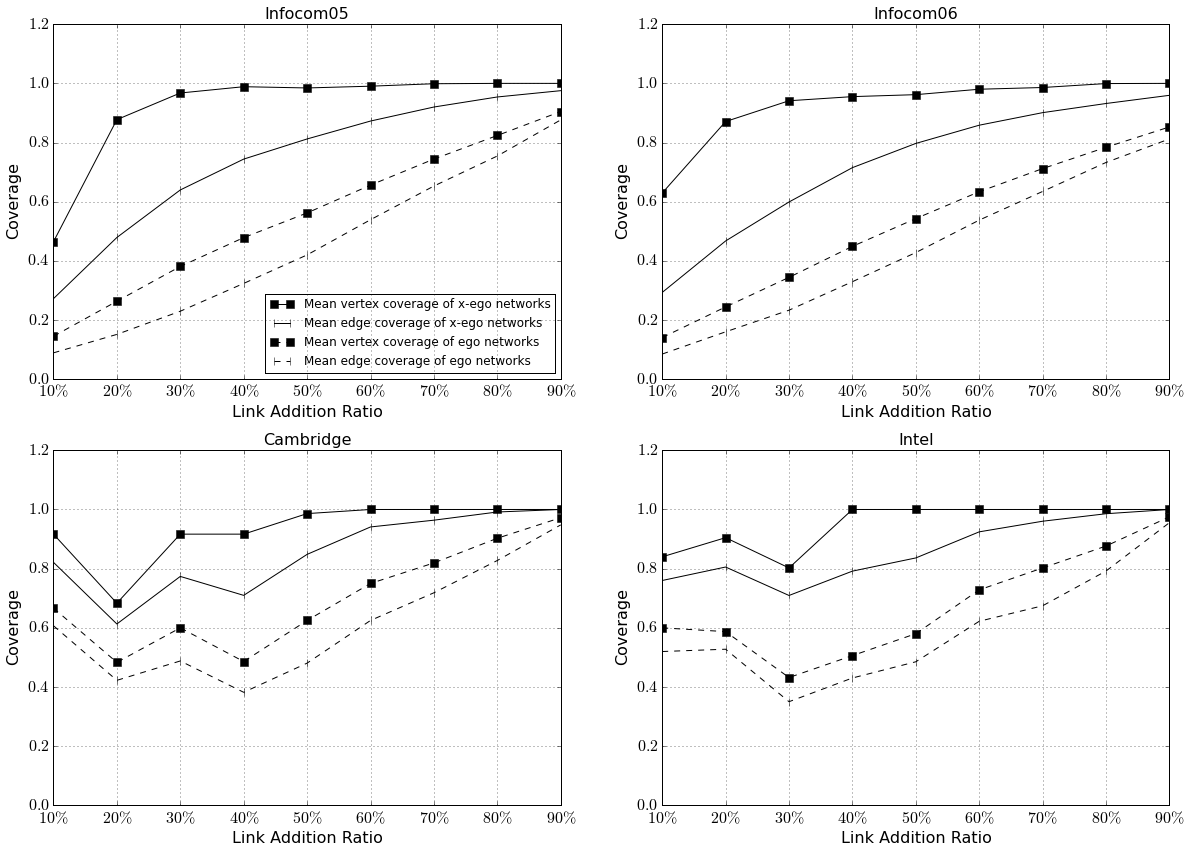

In [23]:
xticklabels = [r'$10\%$', r'$20\%$', r'$30\%$', r'$40\%$', r'$50\%$', r'$60\%$', r'$70\%$', r'$80\%$', r'$90\%$']
yticklabels = [r'$0.0$', r'$0.2$', r'$0.4$', r'$0.6$', r'$0.8$', r'$1.0$', r'$1.2$']
            
fig, axes = plt.subplots(2, 2, figsize=(20, 14))
subfigures = {}
for data_name in data_profile.keys():
    if data_name == 'Infocom05':
        subfigures[data_name] = axes[0][0]
    if data_name == 'Infocom06':
        subfigures[data_name] = axes[0][1]
    if data_name == 'Cambridge':
        subfigures[data_name] = axes[1][0]
    if data_name == 'Intel':
        subfigures[data_name] = axes[1][1]

for data_name in data_profile.keys():
    subfigures[data_name].set_xticks(ind + barWidth/2.)
    subfigures[data_name].set_xticklabels(xticklabels, fontsize=16)
    subfigures[data_name].set_ylim([0.0, 1.2])
    subfigures[data_name].set_yticklabels(yticklabels, fontsize=16)
    
    coverage_dic = SortedDisplayDict(data_profile[data_name]['xego_node_coverage_in_connected_component'])
    coverage_list = [coverage_dic[x] for x in coverage_dic.ordered_keys()]
    subfigures[data_name].plot(ind+barWidth/2., coverage_list, 
                               color='k', linestyle='-', marker='s', markersize=8, 
                               label=r'Mean vertex coverage of x-ego networks') 

    coverage_dic = SortedDisplayDict(data_profile[data_name]['xego_edge_coverage_in_connected_component'])
    coverage_list = [coverage_dic[x] for x in coverage_dic.ordered_keys()]    
    subfigures[data_name].plot(ind+barWidth/2., coverage_list, 
                               color='k', linestyle='-', marker='|', markersize=8, 
                               label=r'Mean edge coverage of x-ego networks')

    coverage_dic = SortedDisplayDict(data_profile[data_name]['ego_node_coverage_in_connected_component'])
    coverage_list = [coverage_dic[x] for x in coverage_dic.ordered_keys()]        
    subfigures[data_name].plot(ind+barWidth/2., coverage_list, 
                               color='k', linestyle='--', marker='s', markersize=8, 
                               label=r'Mean vertex coverage of ego networks') 

    coverage_dic = SortedDisplayDict(data_profile[data_name]['ego_edge_coverage_in_connected_component'])
    coverage_list = [coverage_dic[x] for x in coverage_dic.ordered_keys()]        
    subfigures[data_name].plot(ind+barWidth/2., coverage_list, 
                               color='k', linestyle='--', marker='|', markersize=8, 
                               label=r'Mean edge coverage of ego networks')
    
    subfigures[data_name].set_xlabel('Link Addition Ratio', fontsize=16)
    subfigures[data_name].set_ylabel('Coverage', fontsize=16)
    subfigures[data_name].set_title(data_name, fontsize=16)
    if data_name == 'Infocom05':  
        subfigures[data_name].legend(loc = 4)
    subfigures[data_name].grid(True)      
    #plt.savefig(str(data_name) + '_graph_info_2.pdf', bbox_inches='tight')

## 17. Algorithm execution speed 그래프 생성

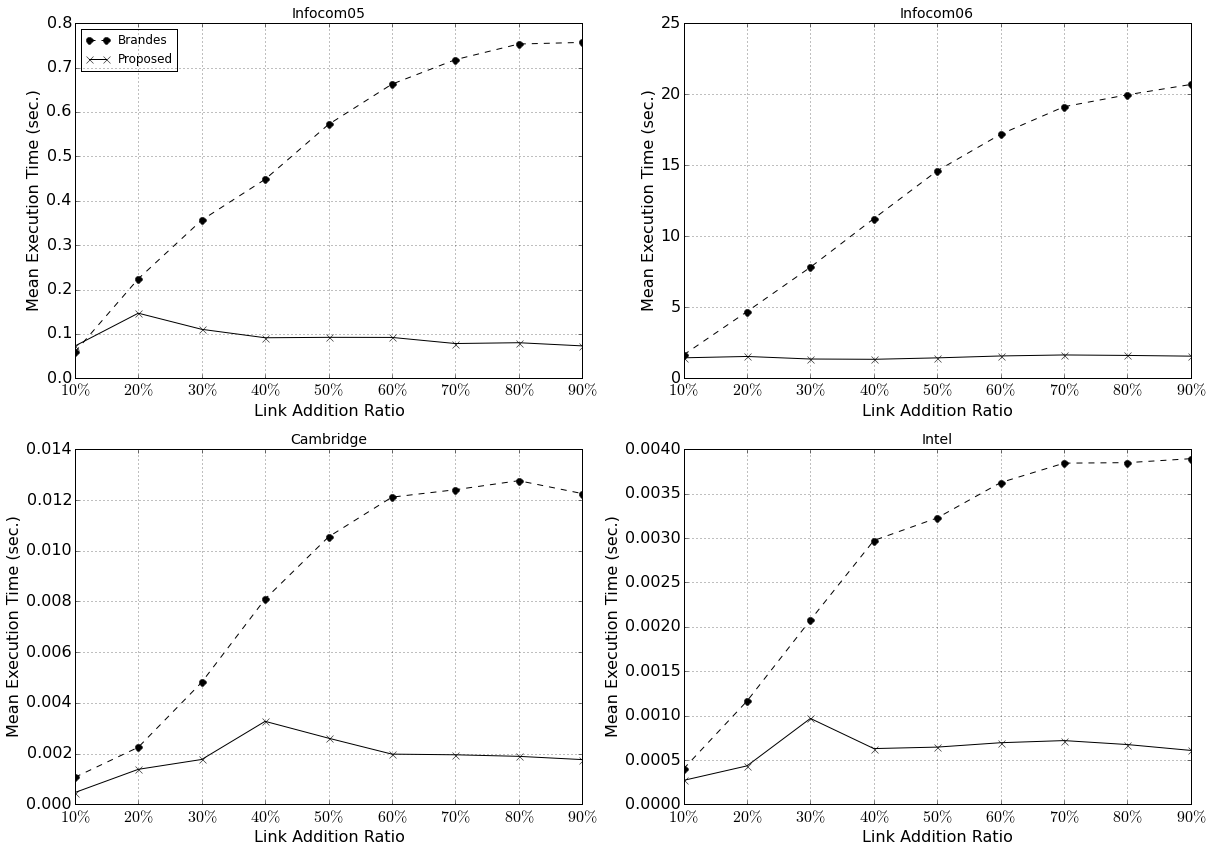

In [37]:
width = 0.35
xticklabels = [r'$10\%$', r'$20\%$', r'$30\%$', r'$40\%$', r'$50\%$', r'$60\%$', r'$70\%$', r'$80\%$', r'$90\%$']

fig, axes = plt.subplots(2, 2, figsize=(20, 14))
subfigures = {}
for data_name in data_profile.keys():
    if data_name == 'Infocom05':
        subfigures[data_name] = axes[0][0]
    if data_name == 'Infocom06':
        subfigures[data_name] = axes[0][1]
    if data_name == 'Cambridge':
        subfigures[data_name] = axes[1][0]
    if data_name == 'Intel':
        subfigures[data_name] = axes[1][1]

for data_name in data_profile.keys():
    subfigures[data_name].set_xticks(ind + width/2.)
    subfigures[data_name].set_xticklabels(xticklabels, fontsize=16)
    subfigures[data_name].tick_params(labelsize=16)

    time_dic = SortedDisplayDict(data_profile[data_name]['Brandes_xego_elapsed_time'])
    time_list = [time_dic[x] for x in time_dic.ordered_keys()]    
    subfigures[data_name].plot(ind + width/2., time_list, 
                               color='k', linestyle='--', marker='o', markersize=7, label='Brandes')

    time_dic = SortedDisplayDict(data_profile[data_name]['Proposed_xego_elapsed_time'])
    time_list = [time_dic[x] for x in time_dic.ordered_keys()]
    subfigures[data_name].plot(ind + width/2., time_list, 
                               color='k', linestyle='-', marker='x', markersize=7, label='Proposed')    

    subfigures[data_name].set_xlabel('Link Addition Ratio', fontsize=16)
    subfigures[data_name].set_ylabel('Mean Execution Time (sec.)', fontsize=16)
    subfigures[data_name].set_title(data_name, fontsize=14)
    if data_name == 'Infocom05':  
        subfigures[data_name].legend(loc = 0)
    subfigures[data_name].grid(True)
    #plt.savefig(str(data_name) + '_xEgo_elapsed_time.pdf', bbox_inches='tight')

## 18. 제안 Algorithm의 높은 효율을 입증하는 Skip ratio 그래프 생성

- 알고리즘 내부에서 수행 횟수에 대한 통계치는 외부 프로그램에 의해 산출함

In [41]:
xEgo_execution_times_stats = [
    [
        [460,   325,  7918,  6645,  5904,  2551, 0.2935, 0.1608, 0.5679],
        [2028,  1251, 51919, 27165, 21036,  4061, 0.3831, 0.4768, 0.8069],
        [4388,  2336, 115355, 32854, 23418,  1739, 0.4676, 0.7152, 0.9257],
        [7028,  3050, 162526, 29473, 21964,   715, 0.5660, 0.8187, 0.9674],
        [10516,  3631, 211242, 25430, 20501,   548, 0.6547, 0.8796, 0.9733],
        [14307,  3630, 224251, 20939, 17071,   400, 0.7463, 0.9066, 0.9766],
        [18302,  3311, 215319, 15831, 13600,    13, 0.8191, 0.9265, 0.9990],
        [22194,  2748, 186157, 11168,  9786,     0, 0.8762, 0.9400, 1.0000],
        [26614,  1498, 104059,  5577,  5366,     0, 0.9437, 0.9464, 1.0000]
    ],

    [
        [9099,  5637, 412125, 222496, 164596, 44187, 0.3805, 0.4601, 0.7315],
        [31350, 16410, 1670923, 465614, 314295, 26755, 0.4766, 0.7213, 0.9149],
        [62275, 28759, 3423942, 521286, 349227,  8322, 0.5382, 0.8478, 0.9762],
        [103727, 39809, 5202046, 471989, 318568,  4051, 0.6162, 0.9093, 0.9873],
        [148526, 46244, 6470079, 400223, 278299,  3864, 0.6886, 0.9381, 0.9861],
        [198961, 47074, 6973541, 333659, 241212,  3537, 0.7634, 0.9522, 0.9853],
        [246885, 43968, 6823894, 260593, 197572,  3185, 0.8219, 0.9618, 0.9839],
        [295703, 36272, 5827108, 196613, 160010,   248, 0.8773, 0.9663, 0.9985],
        [343190, 29228, 4789832, 133306, 113098,     0, 0.9148, 0.9722, 1.0000]
    ],

    [
        [12,     6,    33,    33,    33,     4, 0.5000, 0.0000, 0.8788],
        [31,    16,   122,    97,    88,    30, 0.4839, 0.2049, 0.6591],
        [75,    36,   414,   255,   211,    24, 0.5200, 0.3841, 0.8863],
        [132,    57,   764,   477,   415,    59, 0.5682, 0.3757, 0.8578],
        [233,    86,  1361,   510,   407,    16, 0.6309, 0.6253, 0.9607],
        [355,    91,  1595,   317,   305,     0, 0.7437, 0.8013, 1.0000],
        [429,    78,  1399,   232,   231,     0, 0.8182, 0.8342, 1.0000],
        [526,    58,  1115,   134,   134,     0, 0.8897, 0.8798, 1.0000],
        [620,    20,   400,    40,    40,     0, 0.9677, 0.9000, 1.0000]
    ],

    [
        [6,     3,    13,    13,    13,     4, 0.5000, 0.0000, 0.6923],
        [16,    10,    62,    62,    62,     6, 0.3750, 0.0000, 0.9032],
        [36,    21,   167,   132,   123,    19, 0.4167, 0.2096, 0.8455],
        [56,    26,   239,   202,   196,     0, 0.5357, 0.1548, 1.0000],
        [75,    30,   304,   192,   177,     0, 0.6000, 0.3684, 1.0000],
        [124,    34,   388,   155,   128,     0, 0.7258, 0.6005, 1.0000],
        [150,    36,   461,   138,   102,     0, 0.7600, 0.7007, 1.0000],
        [186,    27,   359,    76,    66,     0, 0.8548, 0.7883, 1.0000],
        [238,     7,    98,    14,    14,     0, 0.9706, 0.8571, 1.0000]
    ]
]

xEgo_execution_dependency1 = []
xEgo_execution_dependency2 = []
xEgo_execution_forloop_dependency2 = []

for i in xrange(0, len(xEgoexecutiontimes_stats)):
    each_list = []
    for j in xrange(0, len(xEgo_execution_times_stats[i])):
        each_list.append(xEgo_execution_times_stats[i][j][6])
    xEgo_execution_dependency1.append(each_list)

for i in xrange(0, len(xEgoexecutiontimes_stats)):
    each_list = []
    for j in xrange(0, len(xEgo_execution_times_stats[i])):
        each_list.append(xEgo_execution_times_stats[i][j][8])
    xEgo_execution_dependency2.append(each_list)

for i in xrange(0, len(xEgoexecutiontimes_stats)):
    each_list = []
    for j in xrange(0, len(xEgo_execution_times_stats[i])):
        each_list.append(xEgo_execution_times_stats[i][j][7])
    xEgo_execution_forloop_dependency2.append(each_list)

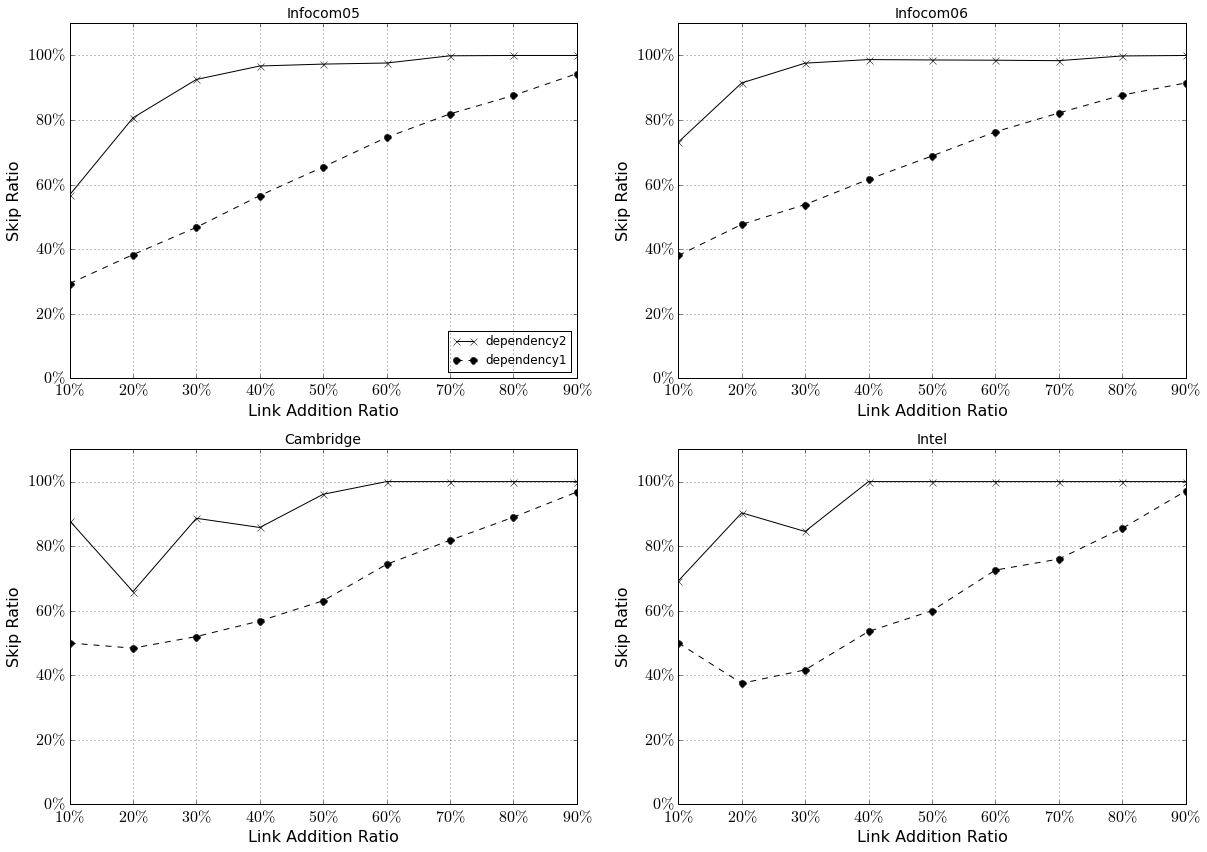

In [45]:
width = 0.35
xticklabels = [r'$10\%$', r'$20\%$', r'$30\%$', r'$40\%$', r'$50\%$', r'$60\%$', r'$70\%$', r'$80\%$', r'$90\%$']
yticklabels = [r'$0\%$', r'$20\%$', r'$40\%$', r'$60\%$', r'$80\%$', r'$100\%$']

fig, axes = plt.subplots(2, 2, figsize=(20, 14))
subfigures = {}
for data_name in data_profile.keys():
    if data_name == 'Infocom05':
        subfigures[data_name] = axes[0][0]
    if data_name == 'Infocom06':
        subfigures[data_name] = axes[0][1]
    if data_name == 'Cambridge':
        subfigures[data_name] = axes[1][0]
    if data_name == 'Intel':
        subfigures[data_name] = axes[1][1]

for data_name in data_profile.keys():
    if data_name == 'Infocom05':
        data_type = 0
    if data_name == 'Infocom06':
        data_type = 1
    if data_name == 'Cambridge':
        data_type = 2
    if data_name == 'Intel':
        data_type = 3
        
    subfigures[data_name].set_xticks(ind + width/2.)
    subfigures[data_name].set_xticklabels(xticklabels, fontsize=16)
    subfigures[data_name].tick_params(labelsize=16)
    subfigures[data_name].set_ylim([0.0, 1.1])   
    subfigures[data_name].set_yticklabels(yticklabels, fontsize=16)
    subfigures[data_name].plot(ind + width/2., xEgo_execution_dependency2[data_type],
                               color='k', linestyle='-', marker='x', markersize=7, label='dependency2')
    subfigures[data_name].plot(ind + width/2., xEgo_execution_dependency1[data_type], 
                               color='k', linestyle='--', marker='o', markersize=7, label='dependency1')
    subfigures[data_name].set_xlabel('Link Addition Ratio', fontsize=16)
    subfigures[data_name].set_ylabel('Skip Ratio', fontsize=16)
    subfigures[data_name].set_title(data_name, fontsize=14)
    if data_name == 'Infocom05':  
        subfigures[data_name].legend(loc = 4)
    subfigures[data_name].grid(True)
    #plt.savefig(str(data_name) + '_xEgo_skip_rate.pdf', bbox_inches='tight')

## 19. 시간이 경과함에 따라 Betweenness 사이의 Correlation 변화 그래프 생성

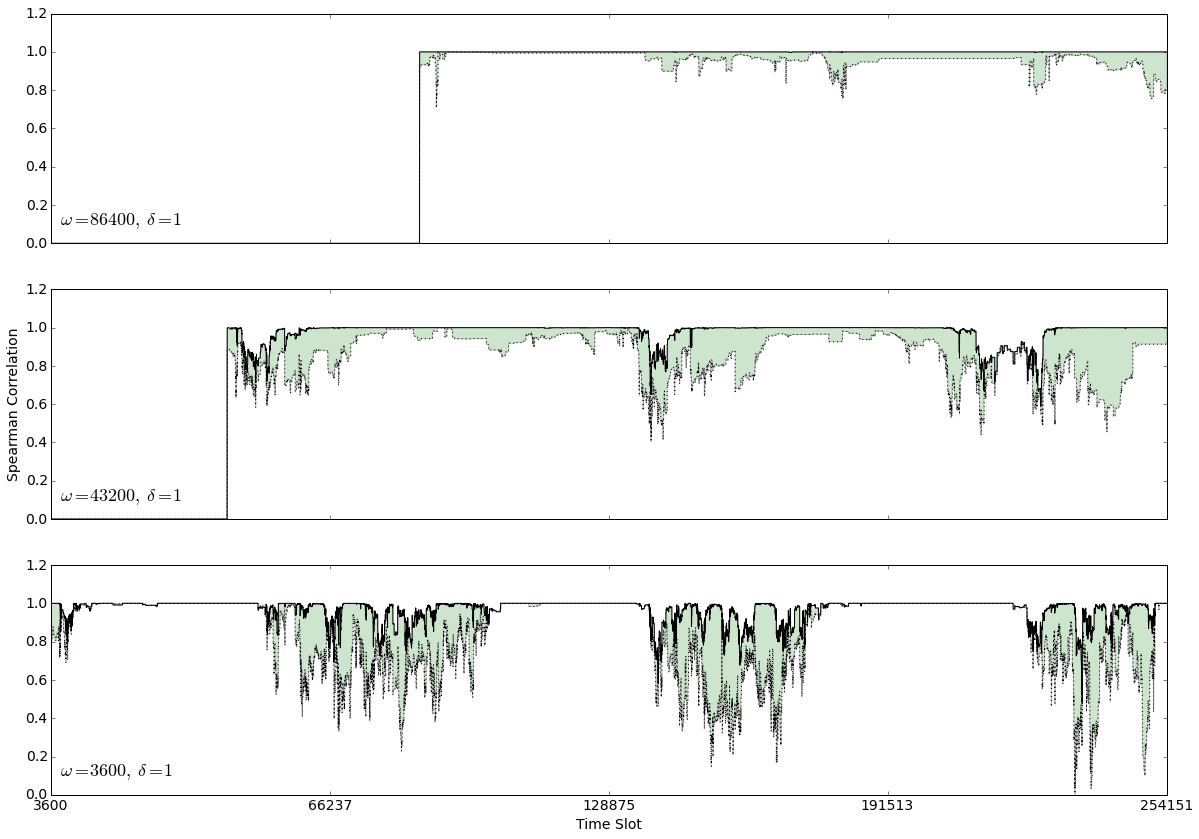

In [60]:
myfile = [None, None, None]
correlationTickList = [None, None, None]
correlationXEgoGlobal = [None, None, None]
correlationEgoGlobal = [None, None, None]

myfile[0] = open('1_cor_spearman_time-3600-1-undirectional.csv', 'r')
myfile[1] = open('1_cor_spearman_time-43200-1-undirectional.csv', 'r')
myfile[2] = open('1_cor_spearman_time-86400-1-undirectional.csv', 'r')

for index in range(0,3):
    r = csv.reader(myfile[index])
    i = 0
    for row in r:
        if i == 0:
            frow = [int(num) for num in row]
            correlationTickList[index] = frow           
        if i == 1:
            frow = [float(num) for num in row]          
            correlationXEgoGlobal[index] = frow
        if i == 2:
            frow = [float(num) for num in row]                      
            correlationEgoGlobal[index] = frow
        i += 1;

    myfile[index].close()

allzero = []
for i in range(0, len(correlationTickList[0]) - len(correlationTickList[1])):
    allzero.append(0.0)
correlationXEgoGlobal[1] = allzero + correlationXEgoGlobal[1] 
correlationEgoGlobal[1] = allzero + correlationEgoGlobal[1]

allzero = []
for i in range(0, len(correlationTickList[0]) - len(correlationTickList[2])):
    allzero.append(0.0)
correlationXEgoGlobal[2] = allzero + correlationXEgoGlobal[2] 
correlationEgoGlobal[2] = allzero + correlationEgoGlobal[2]

min_val = 1.0
ratio = 0.0 
for i in correlationXEgoGlobal[0]:
    if (i != 0.0 and i < min_val):
        min_val = i
    if (i >= 0.8): 
        ratio = ratio + 1

min_val = 1.0
ratio = 0.0
for i in correlationXEgoGlobal[1]:
    if (i != 0.0 and i < min_val):
        min_val = i
    if (i >= 0.8): 
        ratio = ratio + 1

min_val = 1.0
ratio = 0.0
for i in correlationXEgoGlobal[2]:
    if (i != 0.0 and i < min_val):
        min_val = i
    if (i >= 0.8): 
        ratio = ratio + 1

font = {'family': 'serif', 'color': 'black', 'weight': 'normal', 'size': 16}

ind = np.arange(len(correlationTickList[0]))
barWidth = 0.5

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex = True, figsize=(20, 14))

xind = [ind[0]+barWidth/2., 
        ind[int((len(correlationTickList[0])-1)/4)]+barWidth/2., 
        ind[int((len(correlationTickList[0])-1)/2)]+barWidth/2., 
        ind[int((len(correlationTickList[0])-1)*3/4)]+barWidth/2., 
        ind[len(correlationTickList[0])-1]+barWidth/2.] 

#step: 1
xtickLable = [correlationTickList[0][0]-20732, 
              correlationTickList[0][int((len(correlationTickList[0])-1)/4)]-20732, 
              correlationTickList[0][int((len(correlationTickList[0])-1)/2)]-20732, 
              correlationTickList[0][int((len(correlationTickList[0])-1)*3/4)]-20732, 
              correlationTickList[0][len(correlationTickList[0])-1]-20732]
ax1.tick_params(labelsize=14)
ax1.set_ylim(ymin=0.0, ymax=1.2)

#tick start - 107132
correlationXEgoGlobal2 = np.array(correlationXEgoGlobal[2])
correlationEgoGlobal2 = np.array(correlationEgoGlobal[2])
ax1.plot(ind+barWidth/2., correlationXEgoGlobal2, lw=1, ls="-", c="black")
ax1.plot(ind+barWidth/2., correlationEgoGlobal2, lw=1, ls=":", c="black")

ax1.fill_between(ind+barWidth/2., 
                 correlationEgoGlobal2, correlationXEgoGlobal2, 
                 where=correlationXEgoGlobal2 >= correlationEgoGlobal2, 
                 facecolor='green', alpha=0.2)

ax1.fill_between(ind+barWidth/2., 
                 correlationXEgoGlobal2, correlationEgoGlobal2, 
                 where=correlationXEgoGlobal2 < correlationEgoGlobal2, 
                 facecolor='red', alpha=0.2)

ax1.text(2000, 0.1, r'$\omega=86400,\,\delta=1$', fontdict=font, fontsize=18)
#ax1.annotate('107132', xy=(107132, 0.0),  xycoords='data', xytext=(127132, 0.2), textcoords='offset points', arrowprops=dict(facecolor='black', shrink=0.05), horizontalalignment='right', verticalalignment='top')

#tick start - 63932
ax2.set_ylim(ymin=0.0, ymax=1.2)
ax2.tick_params(labelsize=14)
correlationXEgoGlobal2 = np.array(correlationXEgoGlobal[1])
correlationEgoGlobal2 = np.array(correlationEgoGlobal[1])
ax2.plot(ind+barWidth/2., correlationXEgoGlobal2, lw=1, ls="-", c="black")
ax2.plot(ind+barWidth/2., correlationEgoGlobal2, lw=1, ls=":", c="black")

ax2.fill_between(ind+barWidth/2., 
                 correlationEgoGlobal2, correlationXEgoGlobal2, 
                 where=correlationXEgoGlobal2 >= correlationEgoGlobal2, 
                 facecolor='green', alpha=0.2)

ax2.fill_between(ind+barWidth/2., correlationXEgoGlobal2, 
                 correlationEgoGlobal2, where=correlationXEgoGlobal2 < correlationEgoGlobal2, 
                 facecolor='red', alpha=0.2)

ax2.text(2000, 0.1, r'$\omega=43200,\,\delta=1$', fontdict=font, fontsize=18)
#ax2.annotate('63932', xy=(63932, 0.0),  xycoords='data', xytext=(63932, 0.2), textcoords='offset points', arrowprops=dict(facecolor='black', shrink=0.05), horizontalalignment='right', verticalalignment='top')

ax3.set_ylim(ymin=0.0, ymax=1.2)
ax3.set_ylabel('Spearman Correlation', position=(0.1,1.7), fontsize=14)
ax3.set_xlabel('Time Slot', fontsize=14)
ax3.set_xticks(xind)
ax3.tick_params(labelsize=14)
ax3.set_xticklabels(xtickLable, fontsize=14)
correlationXEgoGlobal2 = np.array(correlationXEgoGlobal[0])
correlationEgoGlobal2 = np.array(correlationEgoGlobal[0])
ax3.plot(ind+barWidth/2., correlationXEgoGlobal2, lw=1, ls="-", c="black")
ax3.plot(ind+barWidth/2., correlationEgoGlobal2, lw=1, ls=":", c="black")

ax3.fill_between(ind+barWidth/2., 
                 correlationEgoGlobal2, correlationXEgoGlobal2, 
                 where=correlationXEgoGlobal2 >= correlationEgoGlobal2, 
                 facecolor='green', alpha=0.2)

ax3.fill_between(ind+barWidth/2., 
                 correlationXEgoGlobal2, correlationEgoGlobal2, 
                 where=correlationXEgoGlobal2 < correlationEgoGlobal2, 
                 facecolor='red', alpha=0.2)
ax3.text(2000, 0.1, r'$\omega=3600,\,\delta=1$', fontdict=font, fontsize=18)

#plt.savefig('cor_spearman_time-step-1.pdf', bbox_inches='tight')

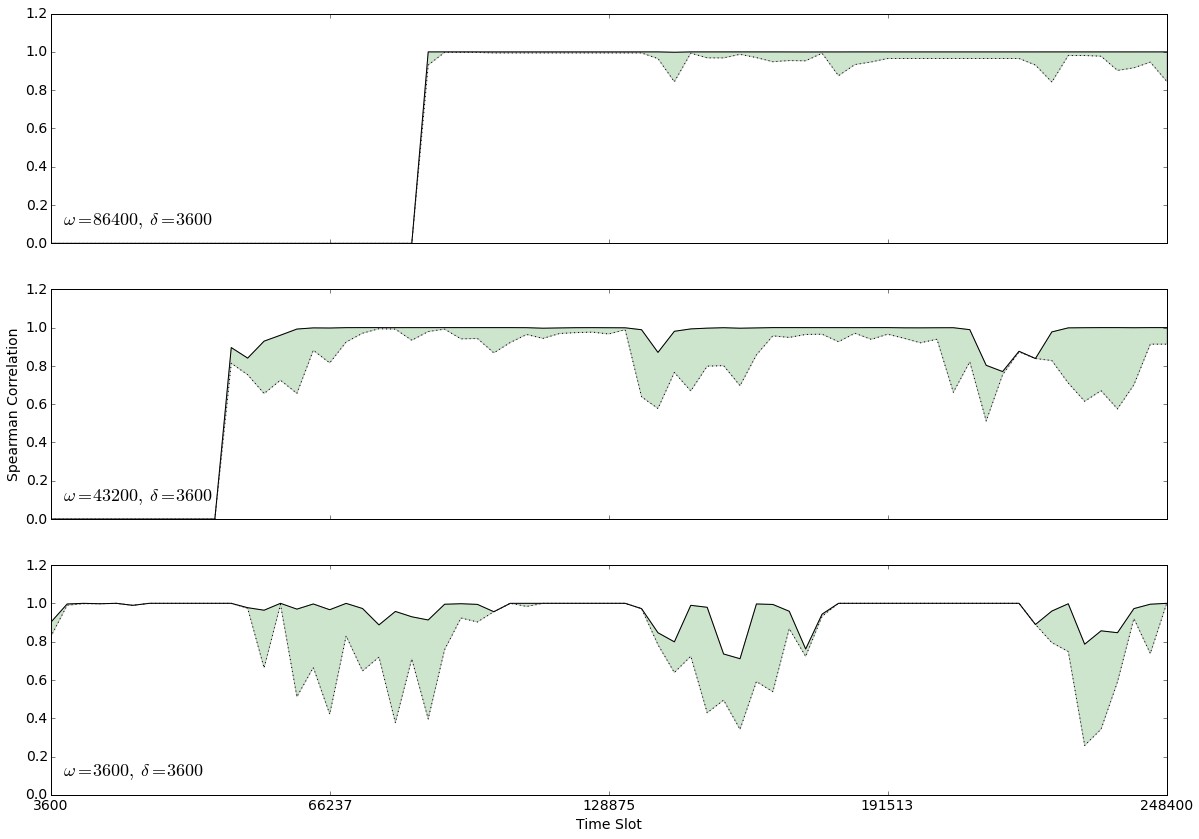

In [64]:
myfile = [None, None, None]
correlationTickList = [None, None, None]
correlationXEgoGlobal = [None, None, None]
correlationEgoGlobal = [None, None, None]

myfile[0] = open('1_cor_spearman_time-3600-3600-undirectional.csv', 'r')
myfile[1] = open('1_cor_spearman_time-43200-3600-undirectional.csv', 'r')
myfile[2] = open('1_cor_spearman_time-86400-3600-undirectional.csv', 'r')

for index in range(0,3):
    r = csv.reader(myfile[index])
    i = 0

    for row in r:
        if i == 0:
            frow = [int(num) for num in row]
            correlationTickList[index] = frow           
        if i == 1:
            frow = [float(num) for num in row]          
            correlationXEgoGlobal[index] = frow
        if i == 2:
            frow = [float(num) for num in row]                      
            correlationEgoGlobal[index] = frow
        i += 1;
    myfile[index].close()

allzero = []
for i in range(0, len(correlationTickList[0]) - len(correlationTickList[1])):
    allzero.append(0.0)
correlationXEgoGlobal[1] = allzero + correlationXEgoGlobal[1] 
correlationEgoGlobal[1] = allzero + correlationEgoGlobal[1]

allzero = []
for i in range(0, len(correlationTickList[0]) - len(correlationTickList[2])):
    allzero.append(0.0)
correlationXEgoGlobal[2] = allzero + correlationXEgoGlobal[2] 
correlationEgoGlobal[2] = allzero + correlationEgoGlobal[2]

min_val = 1.0
ratio = 0.0 
for i in correlationXEgoGlobal[0]:
    if (i != 0.0 and i < min_val):
        min_val = i
    if (i >= 0.8): 
        ratio = ratio + 1

min_val = 1.0
ratio = 0.0
for i in correlationXEgoGlobal[1]:
    if (i != 0.0 and i < min_val):
        min_val = i
    if (i >= 0.8): 
        ratio = ratio + 1

min_val = 1.0
ratio = 0.0
for i in correlationXEgoGlobal[2]:
    if (i != 0.0 and i < min_val):
        min_val = i
    if (i >= 0.8): 
        ratio = ratio + 1

font = {'family': 'serif', 'color': 'black', 'weight': 'normal', 'size': 16}

ind = np.arange(len(correlationTickList[0]))
barWidth=0.5

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex = True, figsize=(20, 14))

xind = [ind[0]+barWidth/2., 
        ind[int((len(correlationTickList[0])-1)/4)]+barWidth/2., 
        ind[int((len(correlationTickList[0])-1)/2)]+barWidth/2., 
        ind[int((len(correlationTickList[0])-1)*3/4)]+barWidth/2., 
        ind[len(correlationTickList[0])-1]+barWidth/2.]    

#step: 3600
xtickLable = [3600, 66237, 128875, 191513, correlationTickList[0][len(correlationTickList[0])-1]-24331]

ax1.set_ylim(ymin=0.0, ymax=1.2)
ax1.tick_params(labelsize=14)

#tick start - 107132
correlationXEgoGlobal2 = np.array(correlationXEgoGlobal[2])
correlationEgoGlobal2 = np.array(correlationEgoGlobal[2])
ax1.plot(ind+barWidth/2., correlationXEgoGlobal2, lw=1, ls="-", c="black")
ax1.plot(ind+barWidth/2., correlationEgoGlobal2, lw=1, ls=":", c="black")

ax1.fill_between(ind+barWidth/2., 
                 correlationEgoGlobal2, correlationXEgoGlobal2, 
                 where=correlationXEgoGlobal2 >= correlationEgoGlobal2, 
                 facecolor='green', alpha=0.2)

ax1.fill_between(ind+barWidth/2., 
                 correlationXEgoGlobal2, correlationEgoGlobal2, 
                 where=correlationXEgoGlobal2 < correlationEgoGlobal2, 
                 facecolor='red', alpha=0.2)    
ax1.text(1, 0.1, r'$\omega=86400,\,\delta=3600$', fontdict=font, fontsize=18)

#tick start - 63932
ax2.set_ylim(ymin=0.0, ymax=1.2)
ax2.tick_params(labelsize=14)
correlationXEgoGlobal2 = np.array(correlationXEgoGlobal[1])
correlationEgoGlobal2 = np.array(correlationEgoGlobal[1])
ax2.plot(ind+barWidth/2., correlationXEgoGlobal2, lw=1, ls="-", c="black")
ax2.plot(ind+barWidth/2., correlationEgoGlobal2, lw=1, ls=":", c="black")

ax2.fill_between(ind+barWidth/2., 
                 correlationEgoGlobal2, correlationXEgoGlobal2, 
                 where=correlationXEgoGlobal2 >= correlationEgoGlobal2, 
                 facecolor='green', alpha=0.2)

ax2.fill_between(ind+barWidth/2., 
                 correlationXEgoGlobal2, correlationEgoGlobal2, 
                 where=correlationXEgoGlobal2 < correlationEgoGlobal2, 
                 facecolor='red', alpha=0.2)    

ax2.text(1, 0.1, r'$\omega=43200,\,\delta=3600$', fontdict=font, fontsize=18)

ax3.set_ylim(ymin=0.0, ymax=1.2)
ax3.set_ylabel('Spearman Correlation', position=(0.1,1.7), fontsize=14)
ax3.set_xlabel('Time Slot', fontsize=14)
ax3.set_xticks(xind)
ax3.tick_params(labelsize=14)
ax3.set_xticklabels(xtickLable, fontsize=14)
correlationXEgoGlobal2 = np.array(correlationXEgoGlobal[0])
correlationEgoGlobal2 = np.array(correlationEgoGlobal[0])
ax3.plot(ind+barWidth/2., correlationXEgoGlobal2, lw=1, ls="-", c="black")
ax3.plot(ind+barWidth/2., correlationEgoGlobal2, lw=1, ls=":", c="black")

ax3.fill_between(ind+barWidth/2., 
                 correlationEgoGlobal2, correlationXEgoGlobal2, 
                 where=correlationXEgoGlobal2 >= correlationEgoGlobal2, 
                 facecolor='green', alpha=0.2)

ax3.fill_between(ind+barWidth/2., 
                 correlationXEgoGlobal2, correlationEgoGlobal2, 
                 where=correlationXEgoGlobal2 < correlationEgoGlobal2, 
                 facecolor='red', alpha=0.2)    

ax3.text(1, 0.1, r'$\omega=3600,\,\delta=3600$', fontdict=font, fontsize=18)

#plt.savefig('cor_spearman_time-step-3600.pdf', bbox_inches='tight')